<b><center>Homework 3 - Team East Meets West<center></b>
<b><center>Due 11:59pm EST Wednesday October 12<center></b>
Team: <b>Cindy Liu and Hazel John</b>

As a very first step, we decided to start with the baseline file provided as part of the homework.
It gave us a good framework to start the rest of the explorations. The first thing that stood out after our initial explorations was that we were filling in the missing values with zeroes.

So for the first run, that was the thing we addressed first. But let's get the setup out of the way:

In [21]:
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC

%matplotlib inline
warnings.filterwarnings('ignore')

We added a simple way to run our classifiers on smaller subsets of the data to save time on failed runs. (Additionally, all of our code used to be in a standalone script, so we originally had a logger setup here as well; but we took it out when we transferred everything into this notebook.)

In [22]:
# Useful ability to debug with smaller datasets (generated using a separate script)
DEBUG = False
if DEBUG:
    TRAINING_DATA = 'trainingDataSubSet.txt'
    TRAINING_TRUTH = 'trainingTruthSubSet.txt'
    TEST_DATA = 'testDataSubSet.txt'
else:
    """ CHANGE TEST_DATA HERE TO PULL BLIND DATASET INSTEAD OF HOMEWORK TEST DATASET """
    TRAINING_DATA = 'trainingData.txt'
    TRAINING_TRUTH = 'trainingTruth.txt'
    TEST_DATA = 'testData.txt'

Here we pull in all the data, check the dimensions, and do a bit of formatting.

In [ ]:
# generate a runid
g_runID = '%s'%datetime.now().strftime('%m-%d-%Y_%H%M')

# Reading files
read_start = time.time()

# Read in the data
X = pd.read_csv(TRAINING_DATA, sep='\t', header=None)
Y = pd.read_csv(TRAINING_TRUTH, sep='\t', header=None)
Xtest = pd.read_csv(TEST_DATA, sep="\t", header=None)

read_end = time.time()
print('Time to read in data: {:.3f}s'.format(read_end - read_start))

# Look at the dimensions of the datasets
print('X.shape: %s, Y.shape: %s, Xtest.shape: %s' % (X.shape, Y.shape, Xtest.shape))

# Flatten output labels array
Y = np.array(Y).ravel()

We got an overall idea of what we were working with by taking a graphical look at the data.

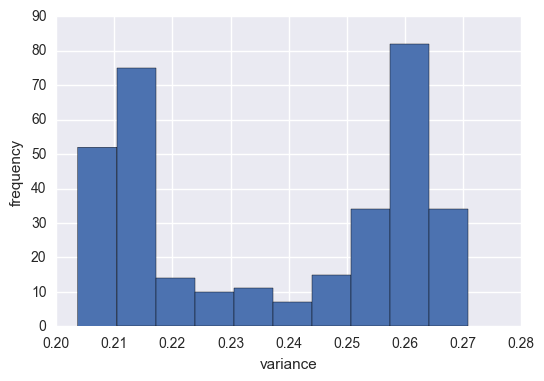

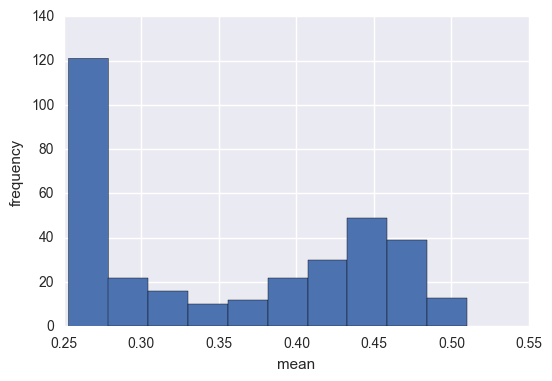

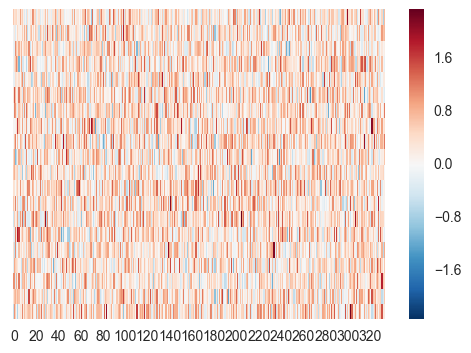

In [28]:
# Do initial analysis of the data
plt.hist(X.var(axis=0))
plt.xlabel('variance')
plt.ylabel('frequency')
plt.show()
plt.hist(X.mean(axis=0))
plt.xlabel('mean')
plt.ylabel('frequency')
plt.show()

# This takes too long with all the rows, so we use a subset
# We see a similar range of values in all columns
sns.heatmap(X[0:20], xticklabels=20, yticklabels=False)

We eventually chose to impute missing values using means, as it seemed to give us better results than using medians or modes.

In [29]:
""" REPLACE MISSING VALUES """

# Impute missing values, we can choose, mean, median or most frequent
# Choosing mean as a standard
strategy = 'mean'
imp = Imputer(missing_values='NaN', copy=False, strategy=strategy, axis=0)
imp.fit_transform(X)   
print('Missing values replaced using %s' % strategy)

Missing values replaced using mean


We also tried a couple of methods for feature reduction. The first was by variance, since there appeared to be a large number of low-variance features from the histogram.

In [33]:
def reduceFeatureswithVariance(Xtrain, Xtest, threshold=0.22)
    # one way of removing low importance features is to remove features with low variability
    # Looking at the variance histogram, we can choose 0.22 as a good cutoff
    selector = VarianceThreshold(threshold = threshold)
    selector.fit(Xtrain)

    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    print('Variance Threshold %0.2f: Keeping %d out of %d features' % (threshold, len(kept_features), Xtrain.shape[1]))

    # Reduce dataset to only include selected features
    Xtrain = selector.transform(Xtrain)
    Xtest = selector.transform(Xtest)

Variance Threshold 0.22: Keeping 198, out of 334 features


But ultimately we went with the random forests method for determining feature importance as it retained fewer features and also gave us better results:

Feature ranking:
1. feature 325 (0.007953)
2. feature 303 (0.007857)
3. feature 78 (0.007834)
4. feature 114 (0.007125)
5. feature 42 (0.006950)
6. feature 264 (0.006496)
7. feature 47 (0.006446)
8. feature 163 (0.005986)
9. feature 146 (0.005985)
10. feature 298 (0.005470)


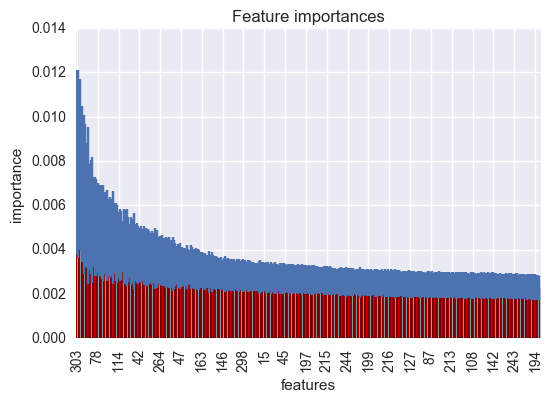

ExtraTreesClassifier: Keeping 97, out of 334 features


In [36]:
def reduceFeatureswithExtraTrees(Y, Xtrain, Xtest)
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

    forest.fit(Xtrain, Y)
    importances = forest.feature_importances_

    # Compute the std. deviations
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Log top 10 features
    print("Feature ranking:")
    for f in range(10):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtrain.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtrain.shape[1]), indices, rotation=90)
    plt.xlim([-1, Xtrain.shape[1]])
    ax = plt.axes()

    # Skip some of the feature labels to reduce crowding
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.set_xlabel('features') 
    ax.set_ylabel('importance')
    plt.show()

    # select features based on importance weights.
    # by default it uses mean importance as the threshold
    selector = SelectFromModel(forest, prefit=True)

    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    print('ExtraTreesClassifier: Keeping %d out of %d features' % (len(kept_features), Xtrain.shape[1]))

    # Reduce dataset to only include selected features    
    Xtrain = selector.transform(Xtrain)
    Xtest = selector.transform(Xtest)

We also tried a couple of different ways of scoring our results, since when we first started we had ridiculously high AUC scores and felt we needed to use a second method to make sure it wasn't all a fluke:

In [8]:
""" COMMONLY USED FUNCTIONS """

def getAUCByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    #Calculate AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], model_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return(roc_auc)
    
def getF1ScoreByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)
    # Binarize the predictions
    model_predict = (model_predict == model_predict.max(axis=1, keepdims=True)).astype(int)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    # Calculate F1 scores
    f1_scores = dict()
    for i in range(4):
        f1_scores[i] = f1_score(y_bin[:, i], model_predict[:, i])
    
    return(f1_scores)

def createSubmission(model, Xtest, filename):
    #Create submission
    y_final_prob = model.predict_proba(Xtest)
    y_final_label = model.predict(Xtest)
    
    sample = pd.DataFrame(np.hstack([y_final_prob.round(5),y_final_label.reshape(y_final_prob.shape[0],1)]))
    sample.columns = ["prob1","prob2","prob3","prob4","label"]
    sample.label = sample.label.astype(int)
    
    #Submit this file to dropbox
    sample.to_csv(filename,sep="\t" ,index=False, header=None)
    print('Submission file created: %s' % filename)

For building our actual model, we started out with the method in the code provided at the beginning. Since there are so many parameters to tweak for each classifier, we ran a grid search to more efficiently identify the optimal parameters for this classifer.

In [37]:
def runRandomForestwithGridSearch(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, Xtrain, Xtest)
    
    # Specify the parameters to tune
    param_grid = {'estimator__n_estimators':[20, 30], 
                  'estimator__max_depth':[10, 20], 
                  'estimator__min_samples_split':[4, 6],
                  'estimator__min_samples_leaf':[2, 4],
                  'estimator__max_features': ['sqrt', 0.25]}
    
    model_to_set = OneVsRestClassifier(RandomForestClassifier(random_state=25, oob_score = True), -1)

    gs_start = time.time()
    model_tuning = GridSearchCV(model_to_set, 
                            param_grid = param_grid, 
                            scoring='f1_weighted',
                            iid=False)
    gs_end = time.time()
    print('Time to run grid search (RandomForest): %0.3fs' % (gs_end - gs_start))

    # Fit the model
    model_tuning.fit(Xtrain, Y)
        
    print('Best score = %d' % model_tuning.best_score_)
    print('Best params = %s' % model_tuning.best_params_)
    print('AUC per class = %s' % getAUCByClass(model_tuning, Xtrain, Y, classes=[1, 2, 3, 4]))
    print('F1 Score per class = %s' % getF1ScoreByClass(model_tuning, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv' % file_id  
    
    createSubmission(model_tuning, Xtest, result_fn)
    
    # Note the end time
    run_end = time.time()
    print('Time to run analysis(RandomForest): %0.3fs' % (run_end - run_start))

The second method we tried was using SVM. We found that even with mostly default parameters, SVM gave us a much better-performing model (in terms of prediction accuracy) than the random forest classifier.

In [38]:
def runSVM(Y, Xtrain, Xtest):
    # Note time to run this setup
    run_start = time.time()

    # Normalize data since accuracy of SVM can severely degrade if it isn't
    # Scale data to normal distribution (gaussian,  mean = 0, variance = 1)
    scaler = StandardScaler().fit(Xtrain)
    X_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)

    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, X_scaled, Xtest_scaled)

    # Guessing on these parameters because running with gridsearch took much too long, so I'm
    #   using the results of smaller runs (largest size = first 5000 rows of training dataset)
    clf = SVC(probability=True, cache_size=1000, C=0.1, kernel='sigmoid', gamma=0.1, class_weight='balanced')

    # Fit the model
    clf.fit(X_scaled, Y)

    print('AUC per class = %s' % getAUCByClass(clf, X_scaled, Y, classes=[1, 2, 3, 4]))
    print('F1 Score per class = %s' % getF1ScoreByClass(clf, Xtrain, Y, classes=[1, 2, 3, 4]))

    # Create results filename
    result_fn = 'TeamEastMeetsWest-%s.csv' % file_id

    if not DEBUG:
        # Predict for the test data and create submission
        createSubmission(clf, Xtest_scaled, result_fn)

    run_end = time.time()
    print('Time to run analysis(SVC): %0.3fs' % (run_end - run_start))

We also used the grid search method with SVM, but it took so much longer than the previous grid searches (we estimate it would have taken ~18 hours to complete) that we ended up just running it on a few subsets of the data to get an idea of which parameters to focus on and some starting values, and running plain SVM on the full dataset. We do not, therefore, recommend running this code/calling this function on a dataset with more than 1000 rows.

In [39]:
def runSVMwithGridSearch(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
       
    # Normalize data since accuracy of SVM can severely degrade if it isn't
    # Scale data to normal distribution (gaussian,  mean = 0, variance = 1)
    scaler = StandardScaler().fit(Xtrain)
    X_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, X_scaled, Xtest_scaled)
    
    param_grid = {
        'kernel': ['poly', 'linear', 'sigmoid'],
        'degree': [2, 4, 5],
        'gamma': [.1, .25, .5],
        'C': [.1, .25, .5]
    }
    
    clf = SVC(probability=True, cache_size=1000)
    
    gs_start = time.time()
    clf_tuned = GridSearchCV(clf, param_grid=param_grid)
    gs_end = time.time()
    
    print('Time to run grid search(SVC): %0.3fs'% (gs_end - gs_start))

    # Fit the model
    clf_tuned.fit(X_scaled, Y)

    print('Best score = %d' % clf_tuned.best_score_)
    print('Best params = %s' % clf_tuned.best_params_)
    print('AUC per class = %s' % 
                getAUCByClass(clf_tuned, X_scaled, Y, classes=[1, 2, 3, 4]))
    print('F1 Score per class = %s' % 
                getF1ScoreByClass(clf_tuned, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv'%file_id  
    
    # Predict for the test data and create submission
    createSubmission(clf_tuned, Xtest_scaled, result_fn)
    
    run_end = time.time()
    print('Time to run analysis(SVC): %0.3fs'% (run_end - run_start))

We additionally tried further improving our decision tree method using AdaBoost, to see how it compared to SVM.

In [13]:
def runDecisionTreewithAdaboost(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, Xtrain, Xtest)
    
    model_start = time.time()
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                               n_estimators=50,
                               learning_rate=1.5,
                               algorithm="SAMME")
    model_end = time.time()
    print('Time to run AdaBoost(DecisionTree): %0.3fs' % (model_end - model_start))

    # Fit the model
    model.fit(Xtrain, Y)
        
    print('Model params = %s' % model.get_params())
    print('AUC per class = %s' % getAUCByClass(model, Xtrain, Y, classes=[1, 2, 3, 4]))
    print('F1 Score per class = %s' % getF1ScoreByClass(model, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv' % g_runID  
    
    createSubmission(model, Xtest, result_fn)
    
    # Note the end time
    run_end = time.time()
    print('Time to run analysis(AdaBoost): %0.3fs' % (run_end - run_start))

Above we have defined the various functions we developed in our exploration. Here we show our path to our current model:

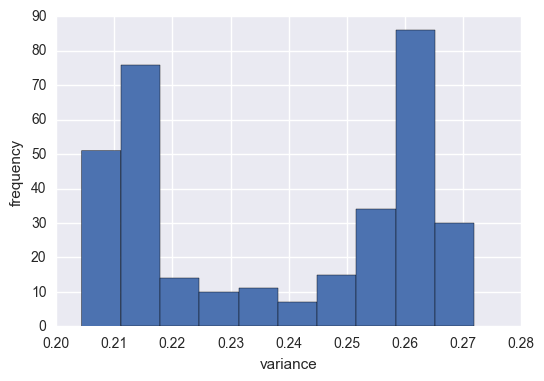

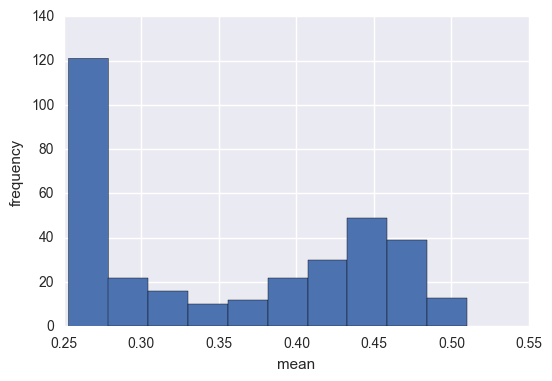

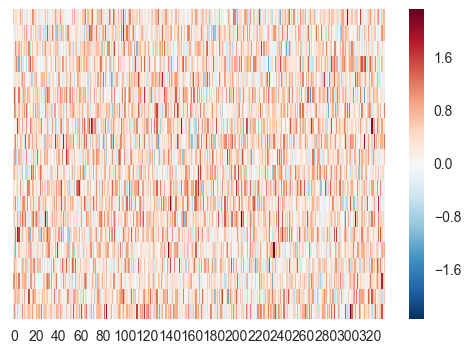

In [19]:
# Run randomforest classifier with gridsearch
#runRandomForestwithGridSearch(Y, X, Xtest)

# Run SVM classifier with gridsearch
# runSVMwithGridSearch(Y, X, Xtest)

# Run SVM classifier without gridsearch
runSVM(Y, X, Xtest)

# Run DecisionTree classifier with AdaBoost
runDecisionTreewithAdaboost(Y, X, Xtest)